In [8]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import json
import cv2
import PIL
import sys

sys.path.append('../')
from cnn_utils import file_utils, vis_utils

import plot_utils

import tensorflow as tf
import keras.backend as K
gpu_ids = [1]
# set gpu id and tf settings
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(g) for g in gpu_ids])
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

load_epoch = 'latest'
#load_epoch = 500

# shapes sim
load_from_dir = './experiments/GLT_synth_shapes100_square-circle-triangle-to-all_ims80-80-3_imgae32-32-32-64-64-64_maxpool_llatent4_dec64-64-64-32-32-32_lr0.0005_l2_lap_l2_regfwt0.1_l2_sigIw0.5'

with open(os.path.join(load_from_dir, 'arch_params.json'), 'r') as f:
	arch_params = json.load(f)
with open(os.path.join(load_from_dir, 'data_params.json'), 'r') as f:
	data_params = json.load(f)

from experiments_VTE import GLTExperimentClass	
exp = GLTExperimentClass.ExperimentGlobalLocalTransforms(data_params, arch_params)
model_name = exp.get_model_name()

model_name, exp_dir, figures_dir, logs_dir, models_dir = file_utils.make_output_dirs(model_name, prompt_delete=False)
exp.save_exp_info(exp_dir, figures_dir, models_dir, logs_dir)

exp.load_data()

# create models and load existing ones if necessary
exp.create_models()

# compile models for training
start_epoch = exp.load_models(models_dir, load_epoch)
exp.compile_models()

exp.create_generators(batch_size=1)
exp._make_eval_gen()

global_transform_latent_dim = arch_params['global_transform_latent_dim']
local_transform_latent_dim = arch_params['local_transform_latent_dim']



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[2018-09-21 14:38:27] Train labels [0 1]
[2018-09-21 14:38:27] Train labels [0 1]
[2018-09-21 14:38:27] Test labels [3]
[2018-09-21 14:38:27] Test labels [3]
[2018-09-21 14:38:27] Y train shapes
[2018-09-21 14:38:27] Y train shapes
[2018-09-21 14:38:27] (200, 3)
[2018-09-21 14:38:27] (200, 3)
[2018-09-21 14:38:27] (200, 3)
[2018-09-21 14:38:27] (200, 3)
[2018-09-21 14:38:27] Y test shapes
[2018-09-21 14:38:27] Y test shapes
[2018-09-21 14:38:27] (100, 3)
[2018-09-21 14:38:27] (100, 3)
[2018-09-21 14:38:27] (100, 3)
[2018-09-21 14:38:27] (100, 3)
[]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stacked_input (InputLayer)      (None, 80, 80, 6)    0                                            
____________________________________________________________

flow_transformer_test
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_input (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 4)            20          z_input[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 2, 2, 1)      0           dense_2[0][0]                    
__________________________________________________________________________________________________
flow_dec_upsamp_0 (UpSampling2D (None, 4, 4, 1)      0           reshape_2[0][0]                  
_______________________________________________________________________________________

Found latest epoch 5000 in dir ./experiments/GLT_synth_shapes100_square-circle-triangle-to-all_ims80-80-3_imgae32-32-32-64-64-64_maxpool_llatent4_dec64-64-64-32-32-32_lr0.0005_l2_lap_l2_regfwt0.1_l2_sigIw0.5/models
Loading model local_transform_encoder from ./experiments/GLT_synth_shapes100_square-circle-triangle-to-all_ims80-80-3_imgae32-32-32-64-64-64_maxpool_llatent4_dec64-64-64-32-32-32_lr0.0005_l2_lap_l2_regfwt0.1_l2_sigIw0.5/models/local_transform_encoder_epoch5000.h5
Loading model flow_transformer_test from ./experiments/GLT_synth_shapes100_square-circle-triangle-to-all_ims80-80-3_imgae32-32-32-64-64-64_maxpool_llatent4_dec64-64-64-32-32-32_lr0.0005_l2_lap_l2_regfwt0.1_l2_sigIw0.5/models/flow_transformer_test_epoch5000.h5
Loading model img_encoder from ./experiments/GLT_synth_shapes100_square-circle-triangle-to-all_ims80-80-3_imgae32-32-32-64-64-64_maxpool_llatent4_dec64-64-64-32-32-32_lr0.0005_l2_lap_l2_regfwt0.1_l2_sigIw0.5/models/img_encoder_epoch5000.h5
[2018-09-21 14:38:31]

In [9]:
# dataset preview im
import IPython
from IPython.core.display import display, HTML

figs_out_dir = './iclr_figs'
if not os.path.isdir(figs_out_dir):
    os.mkdir(figs_out_dir)

    np.random.seed(3)
border_size = 5
n_ex = 5
out_ims = []
labels = [0, 1]
for l in labels:
    label_ims = []
    label_idxs = np.where(exp.Y_source_train[:, l] == 1)[0]
    print(label_idxs)

    np.random.shuffle(label_idxs)
    use_idxs = label_idxs[:n_ex]
    print(use_idxs)
    for i in range(n_ex):
        im = exp.X_source_train[use_idxs[i]]
        label_ims.append(im)
        label_ims.append(np.ones((border_size, im.shape[1], im.shape[2])))
        
    label_im = np.concatenate(label_ims, axis=0)
    out_ims.append(label_im)
    
    if l < 1:
        out_ims.append(np.ones((label_im.shape[0], border_size, label_im.shape[2])))
    
out_im = np.concatenate(out_ims, axis=1) * 255
print(out_im.shape)
# IPython.display.display(PIL.Image.fromarray(out_im[:, :, [2, 1, 0]]))
cv2.imwrite(os.path.join(figs_out_dir, 'shapes_dataset_examples.png'), out_im)
        
    

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
[25 87 38 44 22]
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199]
[181 155 133 109 123]
(425, 165, 3)


True

(40, 80, 80, 3)
(40, 4)


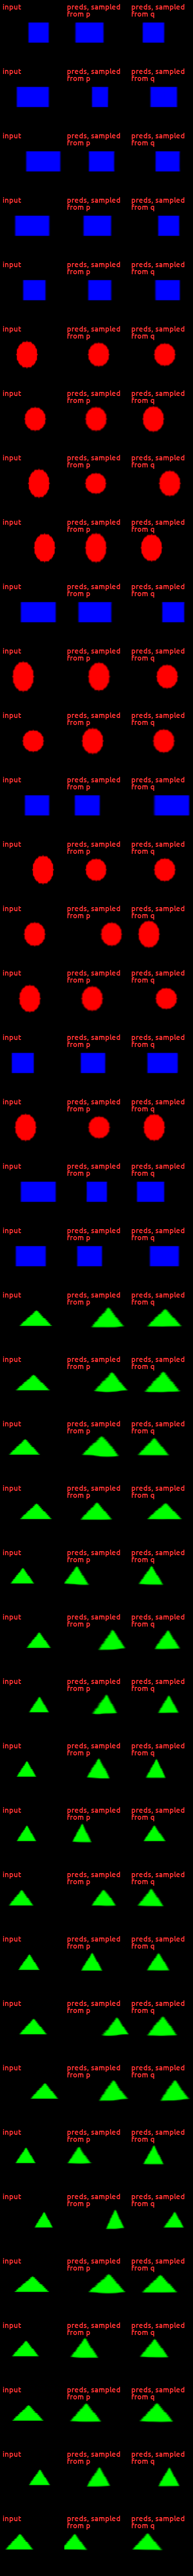

In [10]:
# Try sampling from p(beta) and p(z|x)
import IPython
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important;  }</style>"))
n_digits = 20

input_ims = []
target_ims = []
for i in range(n_digits):
    X, Y, _, _ = next(exp.train_gen)
    input_ims.append(X[0])
    target_ims.append(X[1])
for i in range(n_digits):
    X, Y, _, _ = next(exp.test_gen)
    input_ims.append(X[0])
    target_ims.append(X[1])
    
input_ims = np.concatenate(input_ims, axis=0)
target_ims = np.concatenate(target_ims, axis=0)

batch_size = input_ims.shape[0]
zs_sampled = exp._sample_from_prior(input_ims, batch_size=input_ims.shape[0])

print(input_ims.shape)
print(zs_sampled[0].shape)

preds = exp.tester_model.predict([input_ims] + zs_sampled)

p_out_im = np.concatenate([
    vis_utils.label_ims(input_ims, 'input'),
    vis_utils.label_ims(preds[1], 'preds, sampled from p')], axis=1)


# Try sampling from q(beta|x,y) and q(z|x,y)
preds = exp.trainer_model.predict([input_ims, target_ims])

if not exp.arch_params['global_only']:
    q_out_im = np.concatenate([
    #     vis_utils.label_ims(input_ims, 'input'),
        vis_utils.label_ims(preds[-3], 'preds, sampled from q')], axis=1)
    out_im = np.concatenate([p_out_im, q_out_im], axis=1)
else:
    out_im = p_out_im
IPython.display.display(PIL.Image.fromarray(out_im[:, :, [2, 1, 0]]))

In [11]:
n_samples = 400
import sklearn.decomposition as skld
import sklearn.manifold as sklm
import classification_utils


%matplotlib inline
# ims = [None] * n_samples
# local_z_means = [None] * n_samples
# labels = [None] * n_samples



# run model on several hundred examples and save the vectors
src_ims = [None] * n_samples
tgt_ims = [None] * n_samples
pred_flows = [None] * n_samples
pred_sigmas = [None] * n_samples # only if we are predicting recon sigma
pred_recons = [None] * n_samples
local_qz_means = [None] * n_samples
local_pz_means = [None] * n_samples
local_qz_logvars = [None] * n_samples
local_pz_logvars = [None] * n_samples
global_z_means = [None] * n_samples
global_z_logvars = [None] * n_samples
labels = [None] * n_samples

train_idxs = []
test_idxs = []
label_mapping = exp.label_mapping
for i in range(n_samples):
    if i < n_samples * 0.5:
        X, Y, X_oh, _ = next(exp.train_gen)
        train_idxs.append(i)
    else:
        X, Y, X_oh, _ = next(exp.test_gen)
        test_idxs.append(i)
    label = classification_utils.onehot_to_labels(X_oh, label_mapping=label_mapping)

    preds = exp.trainer_model.predict(X)
    if i==0:
        print('Number of model outputs: {}'.format(len(preds)))
    if not exp.arch_params['local_only']:
        global_z_means[i], global_z_logvars[i] = preds[:2]
        local_z_mean, local_z_logvar = preds[2:4]
    else:
        local_z_mean, local_z_logvar = preds[:2]
        
    if exp.sigma_Iw == 'learned':
        flow = preds[-5]
        pred_sigmas[i] = np.exp(preds[-4]/2.)
    else:
        flow = preds[-4]
        
    pred_recons[i] = preds[-3]
    
    # now see what our p(z|x) network predicts
    preds = exp.vae.img_encoding_model.predict(X[0])
    local_pz_mean = preds[0]
    local_pz_logvar = preds[1]
    
    src_ims[i] = X[0]
    tgt_ims[i] = X[1]
    pred_flows[i]= flow
    
    labels[i] = label
    local_qz_means[i] = local_z_mean
    local_pz_means[i] = local_pz_mean
    
    local_qz_logvars[i] = local_z_logvar
    local_pz_logvars[i] = local_pz_logvar
    
    
src_ims = np.concatenate(src_ims, axis=0)
tgt_ims = np.concatenate(tgt_ims, axis=0)
pred_flows = np.concatenate(pred_flows, axis=0)
labels = np.concatenate(labels, axis=0)
local_qz_means = np.concatenate(local_qz_means, axis=0)
local_pz_means = np.concatenate(local_pz_means, axis=0)
local_qz_logvars = np.concatenate(local_qz_logvars, axis=0)
local_pz_logvars = np.concatenate(local_pz_logvars, axis=0)
pred_recons = np.concatenate(pred_recons, axis=0)

if not exp.arch_params['local_only']:
    global_z_means = np.concatenate(global_z_means, axis=0)
    global_z_logvars = np.concatenate(global_z_logvars, axis=0)
    
if exp.sigma_Iw == 'learned':
    pred_sigmas = np.concatenate(pred_sigmas, axis=0)
    
pca_qz_fitter = skld.PCA(n_components=local_transform_latent_dim)
pcs_qz_means = pca_qz_fitter.fit_transform(local_qz_means)
pcs_qz_plus_std = pca_qz_fitter.transform(local_qz_means + np.exp(local_qz_logvars/2.))
pcs_qz_std = pcs_qz_plus_std - pcs_qz_means

pca_pz_fitter = skld.PCA(n_components=local_transform_latent_dim)
pcs_pz_means = pca_pz_fitter.fit_transform(local_pz_means)
pcs_pz_plus_std = pca_pz_fitter.transform(local_pz_means + np.exp(local_pz_logvars/2.))
pcs_pz_std = pcs_pz_plus_std - pcs_pz_means

qz_tsne = sklm.TSNE(n_components=2).fit_transform(local_qz_means)
pz_tsne = sklm.TSNE(n_components=2).fit_transform(local_pz_means)


Number of model outputs: 6


(400, 4)


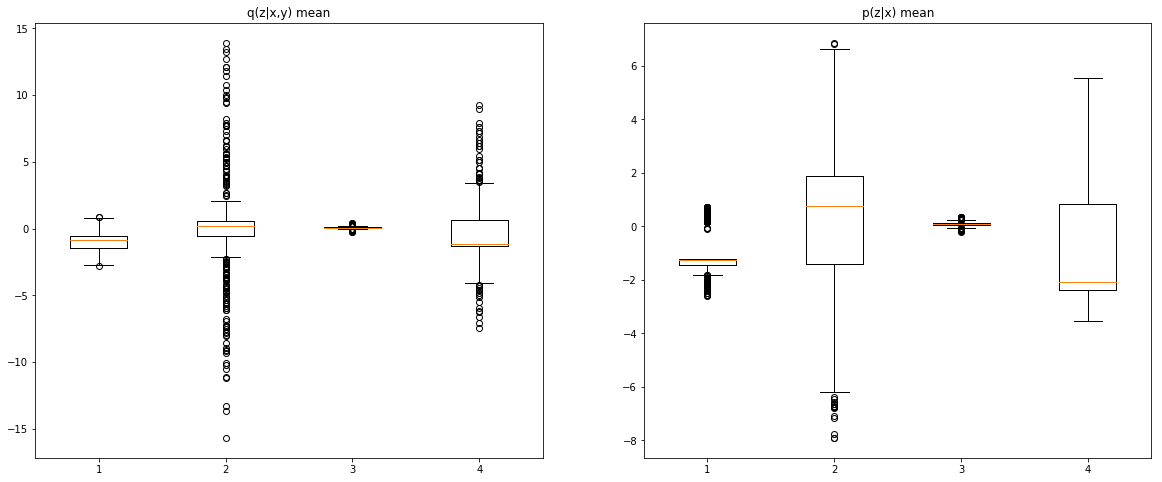

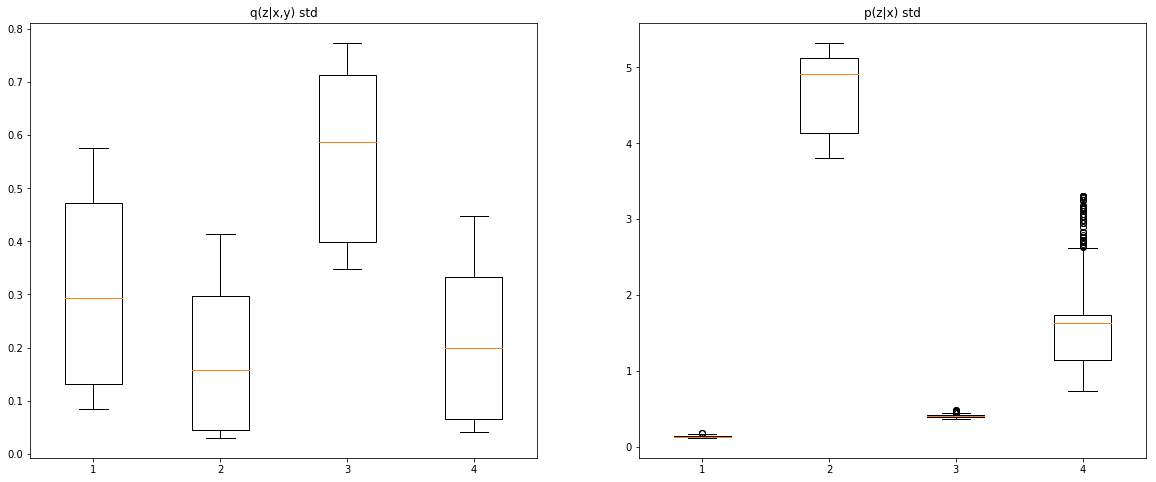

In [12]:
# boxplots of standard deviations
print(local_qz_logvars.shape)
%matplotlib inline
import matplotlib.pyplot as plt

# if we have a local latent variable
if not exp.arch_params['global_only']:
    fig = plt.figure(1, figsize=(20, 8))
    #fig, (ax1, ax2) = fig.subplots(1,2)
    ax1 = fig.add_subplot(121)
    ax1.boxplot(local_qz_means)
    ax1.set_title('q(z|x,y) mean')
    ax2 = fig.add_subplot(122)
    ax2.boxplot(local_pz_means)
    ax2.set_title('p(z|x) mean')
    plt.show()

    fig = plt.figure(2, figsize=(20, 8))
    #fig, (ax1, ax2) = fig.subplots(1,2)
    ax1 = fig.add_subplot(121)
    ax1.boxplot(np.exp(local_qz_logvars/2.))
    ax1.set_title('q(z|x,y) std')
    ax2 = fig.add_subplot(122)
    ax2.boxplot(np.exp(local_pz_logvars/2.))
    ax2.set_title('p(z|x) std')
    plt.show()

if not exp.arch_params['local_only']:
    fig = plt.figure(3, figsize=(20, 8))    
    ax1 = fig.add_subplot(121)
    ax1.boxplot(global_z_means)
    ax1.set_title('beta(z|x,y) mean')
    ax2 = fig.add_subplot(122)
    ax2.boxplot(np.exp(global_z_logvars/2.))
    ax2.set_title('beta(z|x,y) std')
    plt.show()   


(400, 80, 80, 2)
Min: [ -2.781341 -15.704612], max: [ 0.85720843 13.928951  ]
Min: [ -2.781341 -15.704612], max: [ 0.85720843 13.928951  ]
Min: [-1.1415046  -0.24663562], max: [-0.52898496  0.66048354]


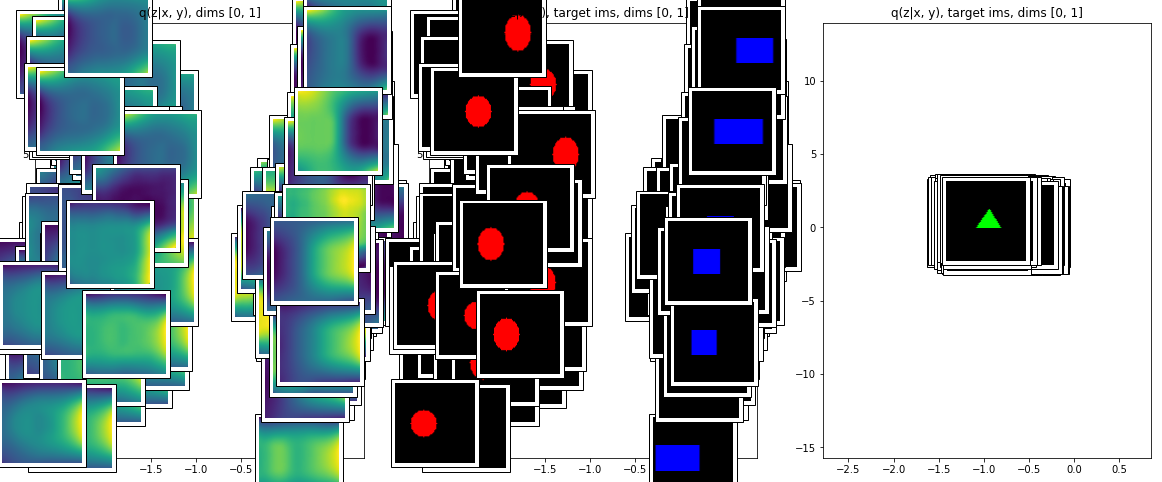

Min: [-2.5921142 -7.910668 ], max: [0.7372249 6.861869 ]
Min: [-2.5921142 -7.910668 ], max: [0.7372249 6.861869 ]
Min: [-1.4494008 -0.5069061], max: [-1.2053065  2.0378172]


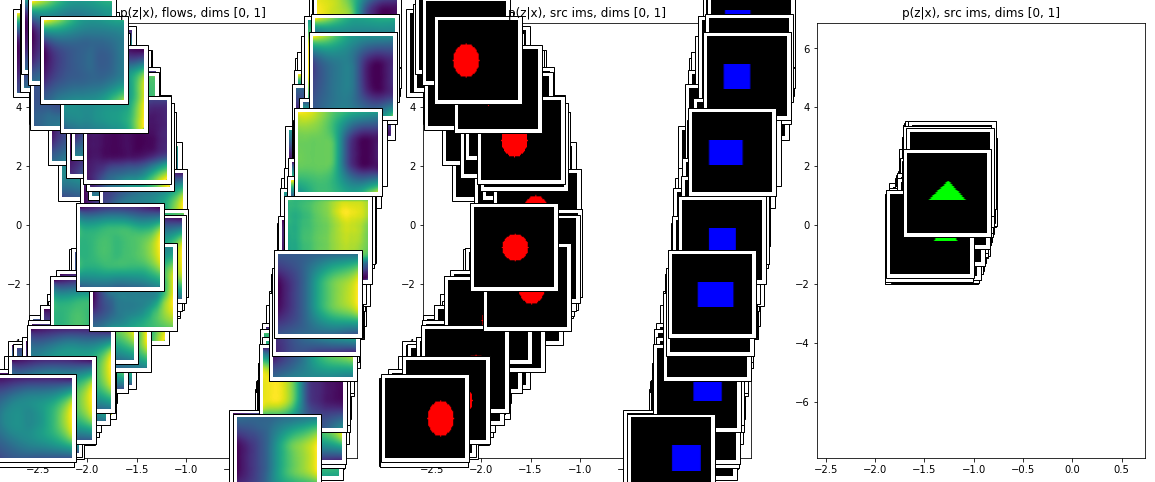

Min: [-2.781341   -0.25528678], max: [0.85720843 0.38825947]
Min: [-2.781341   -0.25528678], max: [0.85720843 0.38825947]
Min: [-1.1415046   0.01588714], max: [-0.52898496  0.08279777]


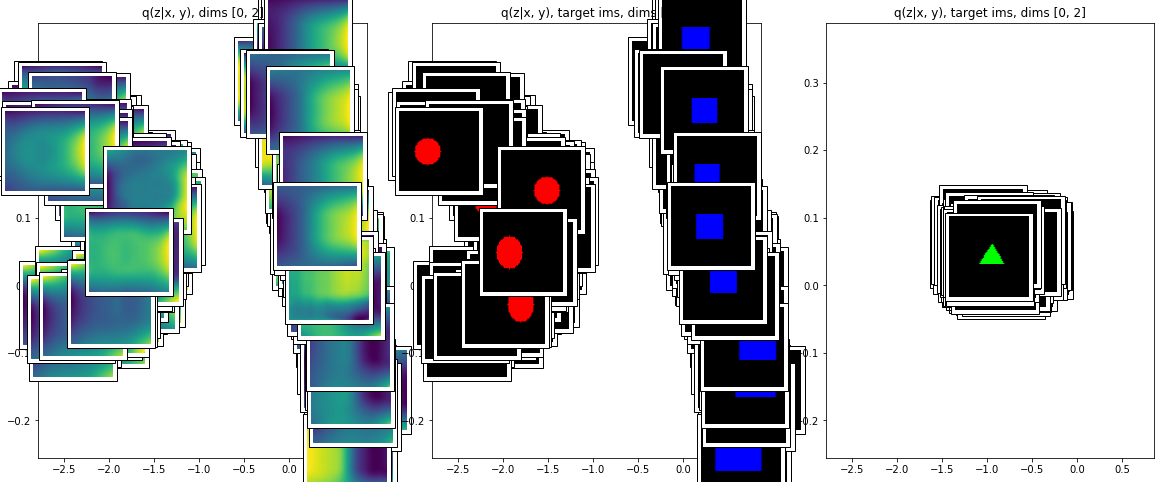

Min: [-2.5921142  -0.22861421], max: [0.7372249  0.34692985]
Min: [-2.5921142  -0.22861421], max: [0.7372249  0.34692985]
Min: [-1.4494008  0.0403913], max: [-1.2053065   0.12634063]


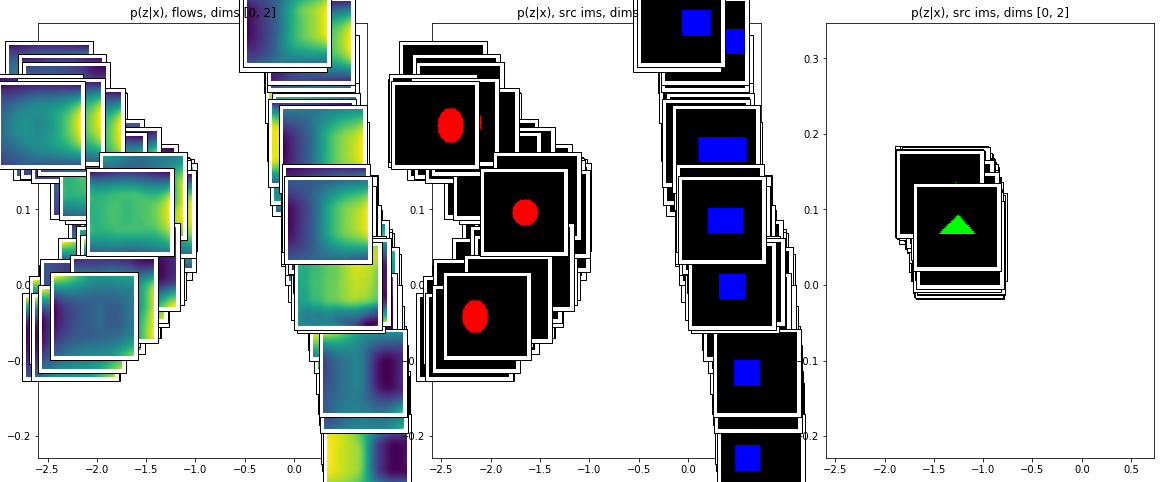

Min: [-2.781341  -7.4748535], max: [0.85720843 9.226741  ]
Min: [-2.781341  -7.4748535], max: [0.85720843 9.226741  ]
Min: [-1.1415046 -1.530374 ], max: [-0.52898496 -0.9421086 ]


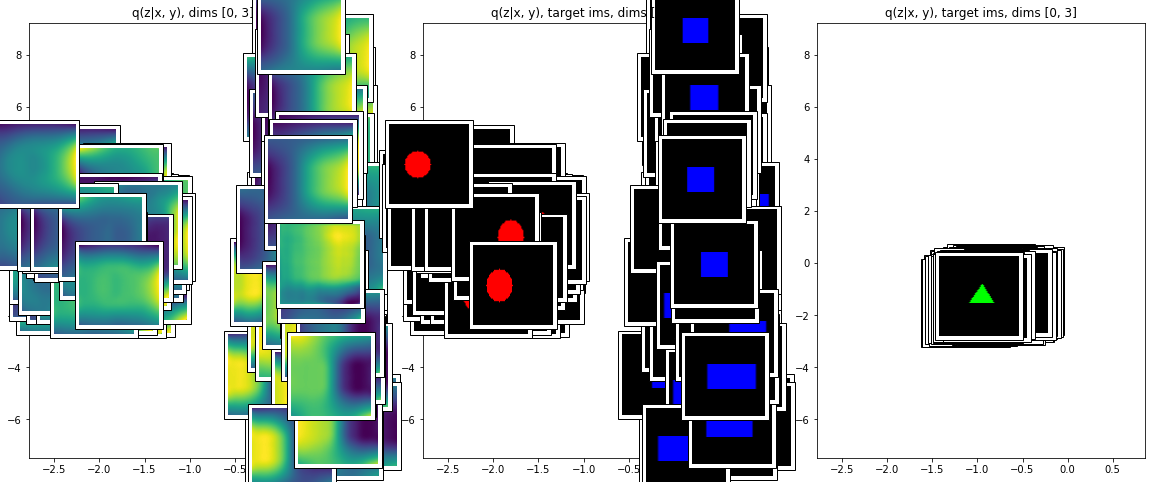

Min: [-2.5921142 -3.5244179], max: [0.7372249 5.5415034]
Min: [-2.5921142 -3.5244179], max: [0.7372249 5.5415034]
Min: [-1.4494008 -2.5890906], max: [-1.2053065 -1.8485731]


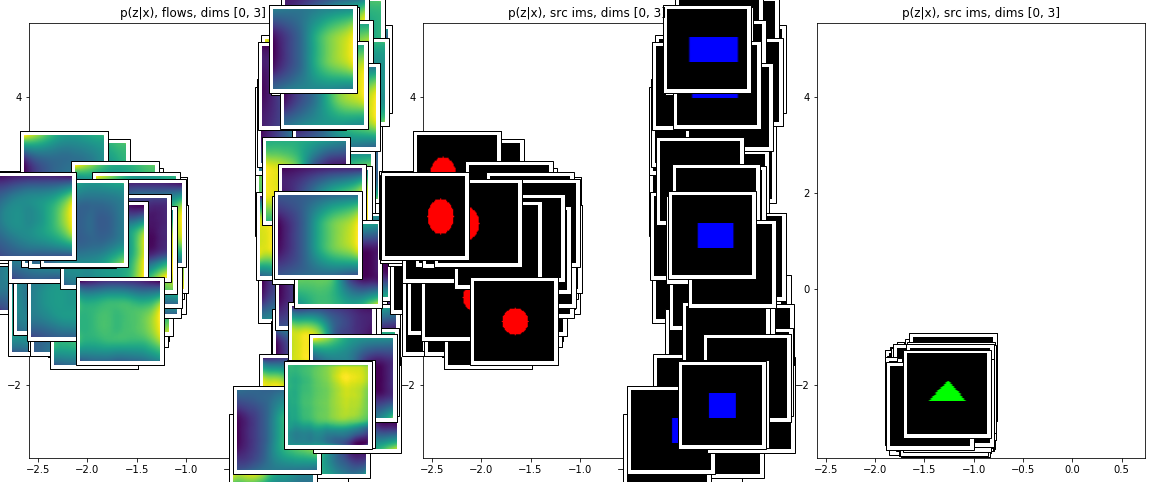

Min: [-15.704612    -0.25528678], max: [13.928951    0.38825947]
Min: [-15.704612    -0.25528678], max: [13.928951    0.38825947]
Min: [-0.24663562  0.01588714], max: [0.66048354 0.08279777]


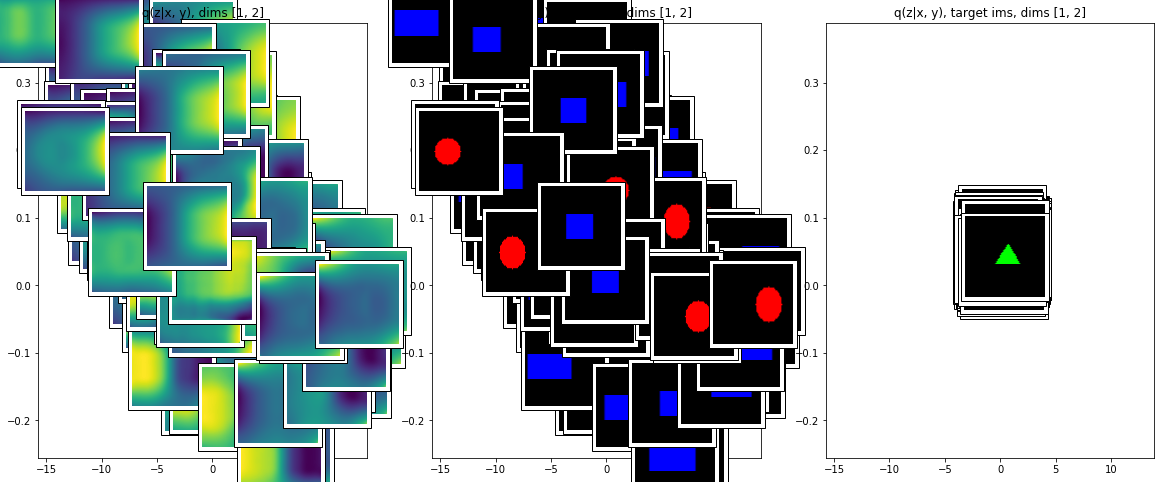

Min: [-7.910668   -0.22861421], max: [6.861869   0.34692985]
Min: [-7.910668   -0.22861421], max: [6.861869   0.34692985]
Min: [-0.5069061  0.0403913], max: [2.0378172  0.12634063]


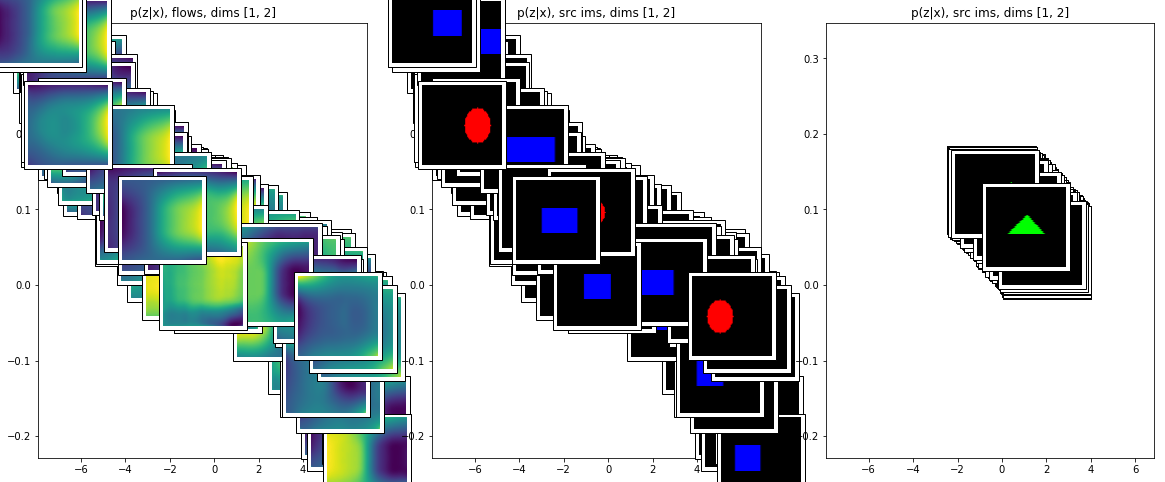

Min: [-15.704612   -7.4748535], max: [13.928951  9.226741]
Min: [-15.704612   -7.4748535], max: [13.928951  9.226741]
Min: [-0.24663562 -1.530374  ], max: [ 0.66048354 -0.9421086 ]


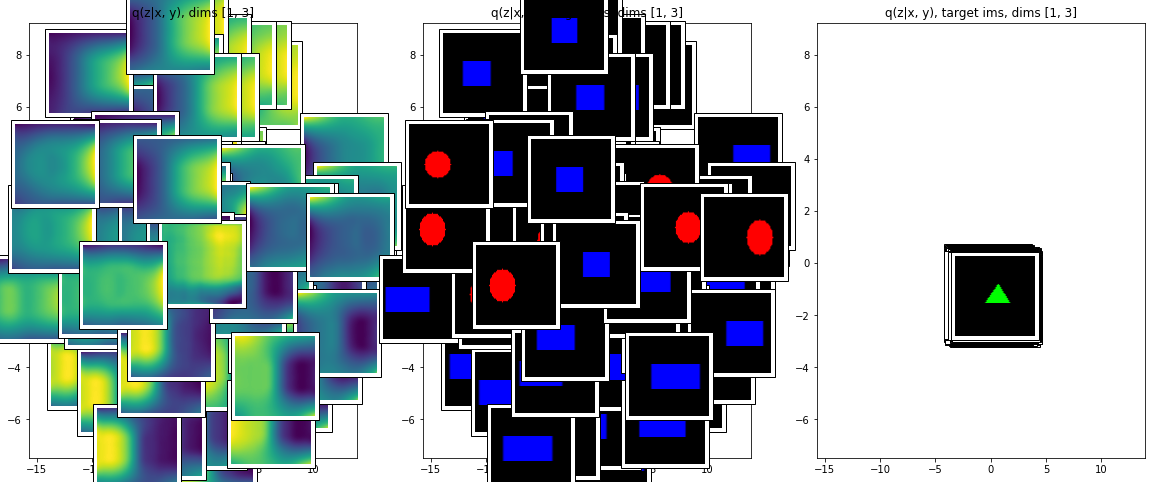

Min: [-7.910668  -3.5244179], max: [6.861869  5.5415034]
Min: [-7.910668  -3.5244179], max: [6.861869  5.5415034]
Min: [-0.5069061 -2.5890906], max: [ 2.0378172 -1.8485731]


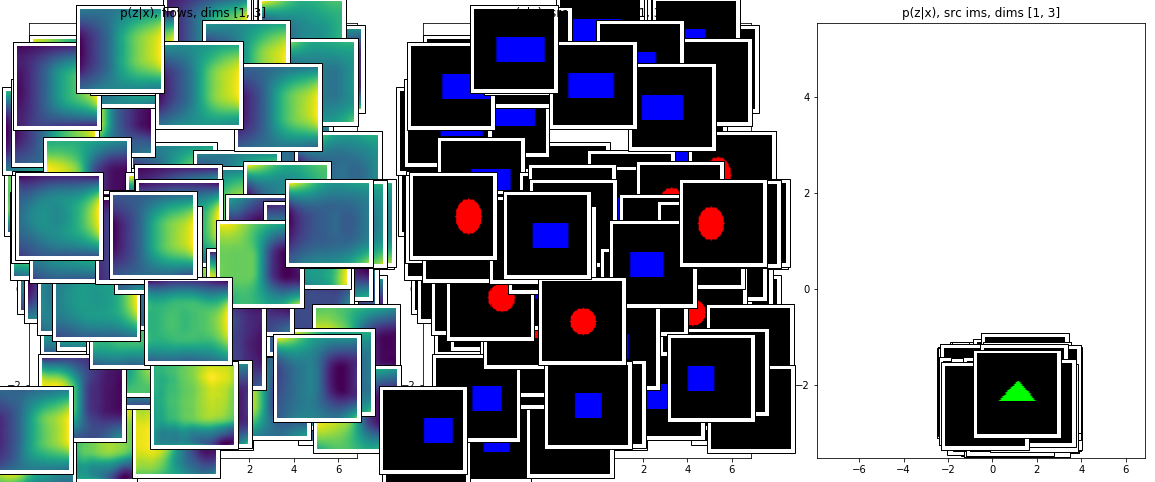

Min: [-0.25528678 -7.4748535 ], max: [0.38825947 9.226741  ]
Min: [-0.25528678 -7.4748535 ], max: [0.38825947 9.226741  ]
Min: [ 0.01588714 -1.530374  ], max: [ 0.08279777 -0.9421086 ]


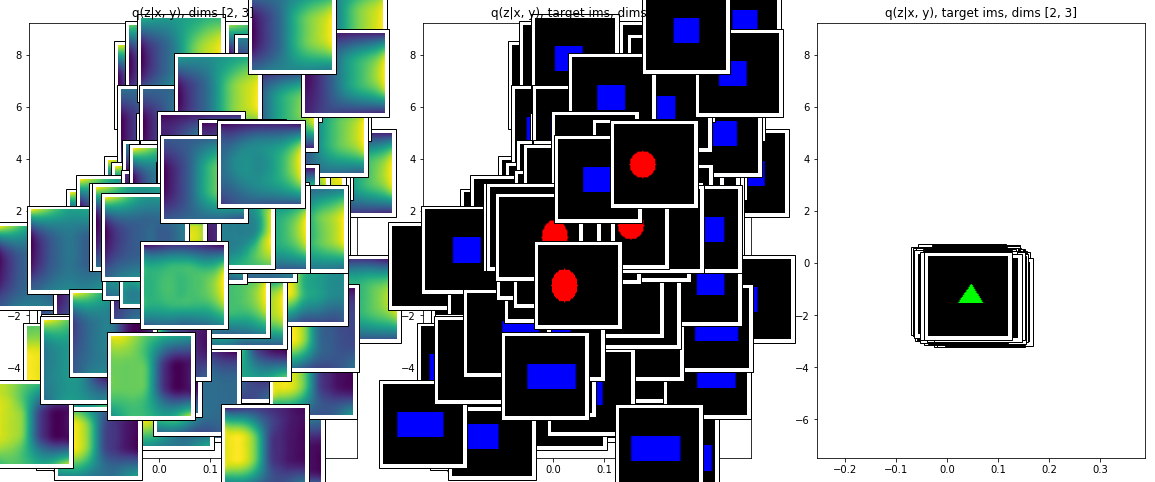

Min: [-0.22861421 -3.5244179 ], max: [0.34692985 5.5415034 ]
Min: [-0.22861421 -3.5244179 ], max: [0.34692985 5.5415034 ]
Min: [ 0.0403913 -2.5890906], max: [ 0.12634063 -1.8485731 ]


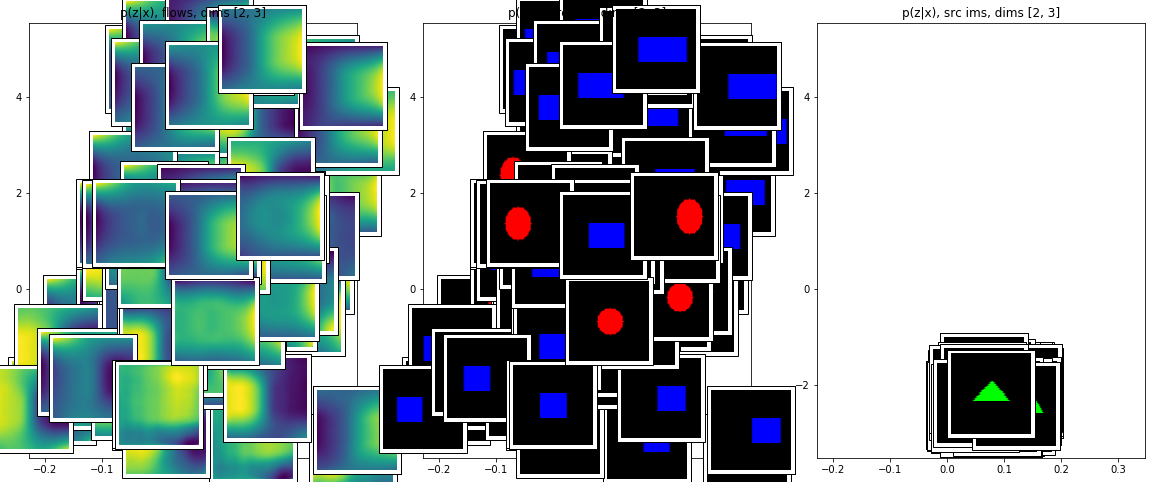

In [13]:
import matplotlib.pyplot as plt
# show embeddings from q(z|x,y) and p(z|x)
pred_flow_ims = vis_utils.label_ims(pred_flows, clip_flow=10)
print(pred_flows.shape)
_, h, w, _ = pred_flows.shape

flow_vectors = np.mean(pred_flows[:, h/2-10:h/2+10, w/2-10:w/2+10, :], 
                       axis=(1, 2))

if local_transform_latent_dim == 2:
    plot_dims = [[0, 1]]
if local_transform_latent_dim == 3:
    plot_dims = [[0, 1], [0, 2], [[1, 2]]]    
elif local_transform_latent_dim >= 4:
    plot_dims = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]

# split into train and test for easy visualization
train_qz_means = local_qz_means[train_idxs]
test_qz_means = local_qz_means[test_idxs]

train_pz_means = local_pz_means[train_idxs]
test_pz_means = local_pz_means[test_idxs]

for pd in plot_dims:
    fig = plt.figure(1, figsize=(20, 8))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    plot_utils.visualize_embedding(train_qz_means[:, pd], pred_flows[train_idxs], labels[train_idxs], 
                                   'q(z|x, y), dims {}'.format(pd), ax1)
    _, x_lims, y_lims = plot_utils.visualize_embedding(train_qz_means[:, pd], tgt_ims[train_idxs], labels[train_idxs], 
                                                       'q(z|x, y), target ims, dims {}'.format(pd), ax2)
    plot_utils.visualize_embedding(test_qz_means[:, pd], tgt_ims[test_idxs], labels[test_idxs], 
                                   'q(z|x, y), target ims, dims {}'.format(pd), ax3, x_lims=x_lims, y_lims=y_lims)
    #plot_embedding(local_qz_means[:, plot_dims], pred_sigmas_vis, labels, 'sigmas', ax3)
    plt.show()

    fig = plt.figure(1, figsize=(20, 8))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    plot_utils.visualize_embedding(train_pz_means[:, pd], pred_flows[train_idxs], labels[train_idxs], 'p(z|x), flows, dims {}'.format(pd), ax1)
    _, x_lims, y_lims = plot_utils.visualize_embedding(train_pz_means[:, pd], src_ims[train_idxs], labels[train_idxs], 'p(z|x), src ims, dims {}'.format(pd), ax2)
    plot_utils.visualize_embedding(test_pz_means[:, pd], src_ims[test_idxs], labels[test_idxs], 
                                   'p(z|x), src ims, dims {}'.format(pd), ax3, x_lims=x_lims, y_lims=y_lims)
    #plot_embedding(local_pz_means[:, plot_dims], pred_sigmas_vis, labels, 'sigmas', ax3)

    #plot_vectors(local_pz_means[:, plot_dims], flow_vectors, ax3)
    plt.show()



if not exp.arch_params['local_only']:
    fig = plt.figure(1, figsize=(20, 8))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    plot_utils.visualize_embedding(global_z_means, pred_flows, labels, 'p(beta|x), flows', ax1)
    plot_utils.visualize_embedding(global_z_means, src_ims, labels, 'p(beta|x), src ims', ax2)
    plot_utils.visualize_embedding(global_z_means, src_ims, labels, 'p(beta|x), src ims', ax2)
    plt.show()
    

    

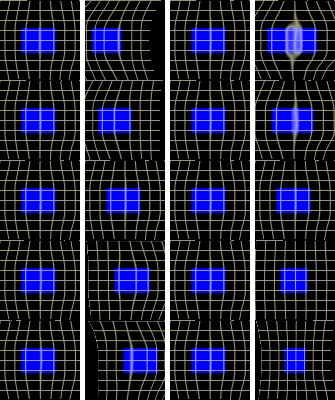

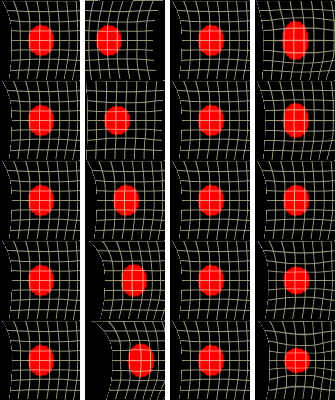

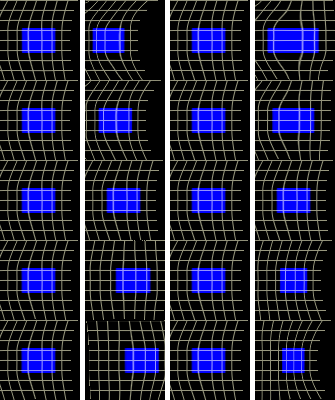

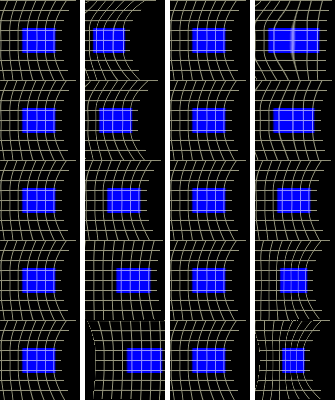

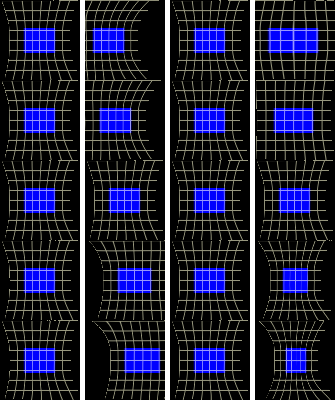

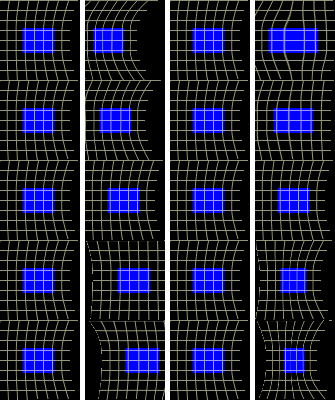

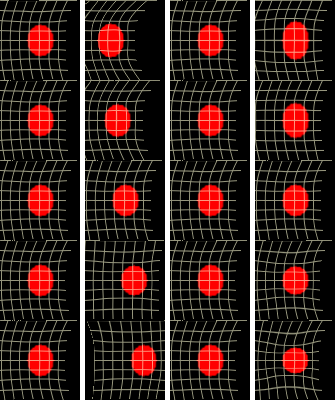

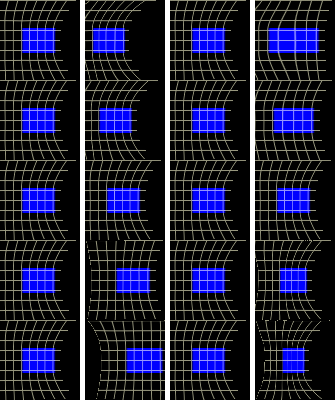

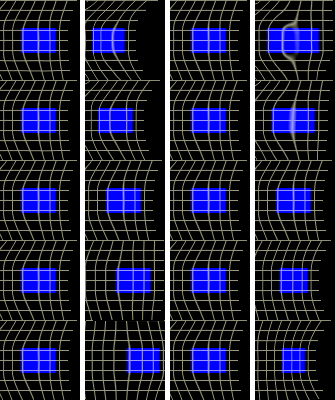

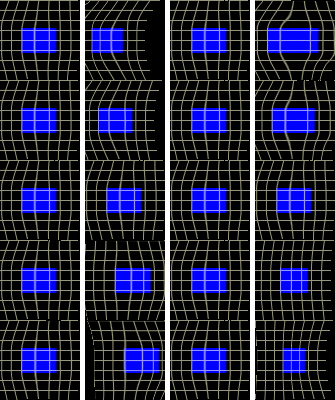

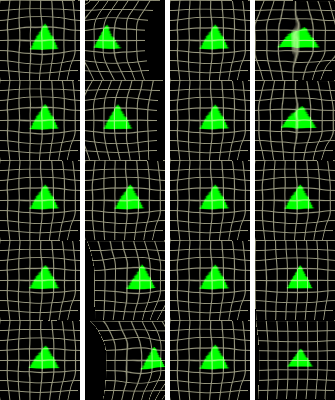

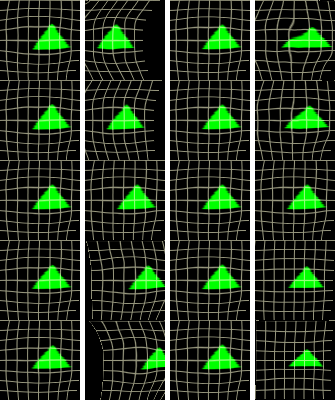

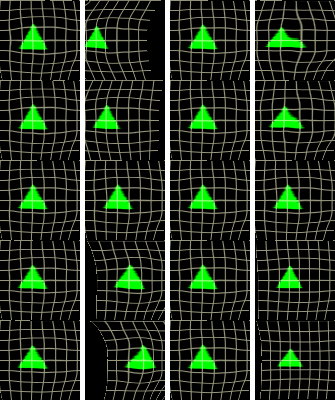

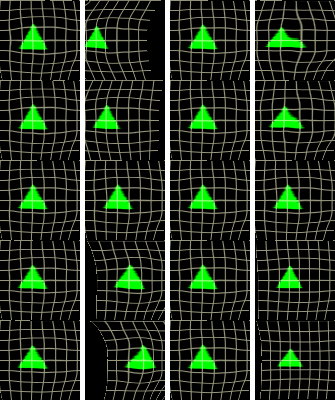

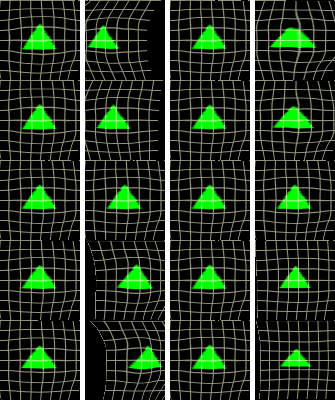

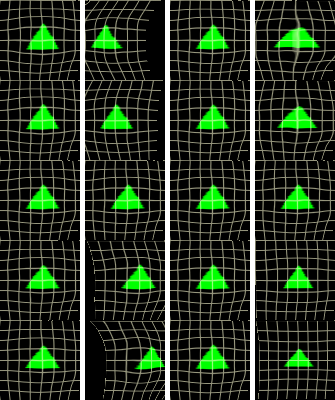

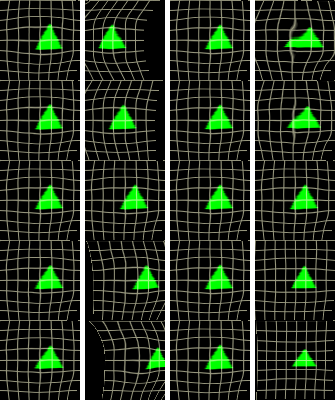

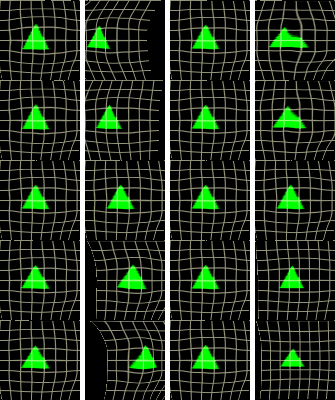

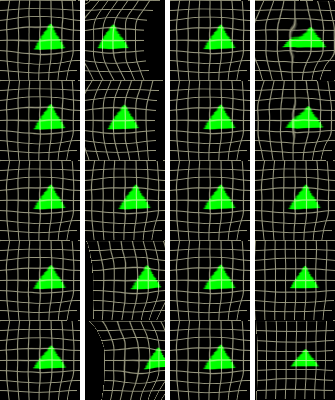

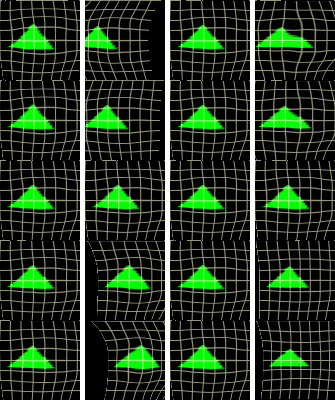

In [14]:
# visualize what happens when we sweep local z
border_size = 5
import IPython
n_digits = 10

plot_pcs = False

Xs = []
Ys = []
for i in range(n_digits):
    X, Y, _, _ = next(exp.train_gen)
    Xs.append(X)
    Ys.append(Y)
for i in range(n_digits):
    X, Y, _, _ = next(exp.test_gen)
    Xs.append(X)
    Ys.append(Y)
    
for i in range(len(Xs)):
    X = Xs[i]
    Y = Ys[i]
    
    eval_batch_size = 1
    n_vals = 5
    max_val = 2
    z_range = np.linspace(-max_val, max_val, n_vals, endpoint=True).tolist()

    input_im = X[0]
    local_pz_mean, local_pz_logvar = exp.vae.img_encoding_model.predict(input_im)

    global_z = np.zeros((eval_batch_size, global_transform_latent_dim))
    
    out_im = []
    for zdim in range(local_transform_latent_dim):
        z_dim_ims = [None] * n_vals
        local_z = local_pz_mean.copy()  # set all dimensions to mean for now

        for zvi, zv in enumerate(z_range):
            if plot_pcs:
                local_z[0, zdim] = local_z_mean[0, zdim] + pcs_pz_std[0, zdim] * zv
                local_z = pca_pz_fitter.inverse_transform(local_z)
            else:
                dim_val = local_pz_mean[0, zdim] + np.exp(local_pz_logvar[0, zdim] / 2.) * zv
                local_z[0, zdim] = dim_val
            
            if not exp.arch_params['local_only']:
                preds = exp.vae.tester_model.predict([input_im, global_z, local_z])
            else:
                preds = exp.vae.tester_model.predict([input_im, local_z])
                
                
            mesh = vis_utils.flow_to_grid(preds[0][0], spacing=10)[:, :, np.newaxis]  # black and white
            mesh = np.concatenate([
                mesh * 0.5, mesh * 0.6, mesh * 0.6], axis=-1)  # pale yellow color
            transformed = preds[1][0]
            
            overlaid = np.clip(transformed + mesh, 0., 1.)
            
            z_dim_ims[zvi] = overlaid

        z_dim_im = np.concatenate(z_dim_ims, axis=0)
        out_im.append(z_dim_im)
        if zdim < local_transform_latent_dim - 1:
            out_im.append(np.ones((z_dim_im.shape[0], border_size, z_dim_im.shape[2])))
        
    out_im = (np.concatenate(out_im, axis=1) * 255).astype(np.uint8)
    
    cv2.imwrite(os.path.join(figs_out_dir, 'local_z_sweep_{}.png'.format(i)), out_im )
    IPython.display.display(PIL.Image.fromarray(out_im[:, :, [2, 1, 0]]))

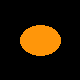

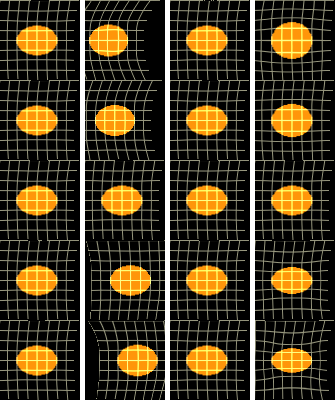

In [30]:
# test shape
test_im = np.zeros((exp.img_shape))

test_im = cv2.ellipse(test_im, 
            (int(round(test_im.shape[1]/2.)), int(round(test_im.shape[0]/2.))),
            (20, 15),
            0, 0, 360,
            (10, 150, 255),
            -1
           ).astype(np.uint8)
IPython.display.display(PIL.Image.fromarray(test_im[:, :, [2, 1, 0]]))

test_im = test_im[np.newaxis, :, :, :]/255.
zs = exp._sample_from_prior(test_im, batch_size = 1)
preds = exp.vae.tester_model.predict([test_im] + zs)

eval_batch_size = 1
n_vals = 5
max_val = 2
z_range = np.linspace(-max_val, max_val, n_vals, endpoint=True).tolist()

input_im = test_im
local_pz_mean, local_pz_logvar = exp.vae.img_encoding_model.predict(input_im)

global_z = np.zeros((eval_batch_size, global_transform_latent_dim))

out_im = []
for zdim in range(local_transform_latent_dim):
    z_dim_ims = [None] * n_vals
    local_z = local_pz_mean.copy()  # set all dimensions to mean for now

    for zvi, zv in enumerate(z_range):
        if plot_pcs:
            local_z[0, zdim] = local_z_mean[0, zdim] + pcs_pz_std[0, zdim] * zv
            local_z = pca_pz_fitter.inverse_transform(local_z)
        else:
            dim_val = local_pz_mean[0, zdim] + np.exp(local_pz_logvar[0, zdim] / 2.) * zv
            local_z[0, zdim] = dim_val

        if not exp.arch_params['local_only']:
            preds = exp.vae.tester_model.predict([input_im, global_z, local_z])
        else:
            preds = exp.vae.tester_model.predict([input_im, local_z])


        mesh = vis_utils.flow_to_grid(preds[0][0], spacing=10)[:, :, np.newaxis]  # black and white
        mesh = np.concatenate([
            mesh * 0.5, mesh * 0.6, mesh * 0.6], axis=-1)  # pale yellow color
        transformed = preds[1][0]

        overlaid = np.clip(transformed + mesh, 0., 1.)

        z_dim_ims[zvi] = overlaid

    z_dim_im = np.concatenate(z_dim_ims, axis=0)
    out_im.append(z_dim_im)
    if zdim < local_transform_latent_dim - 1:
        out_im.append(np.ones((z_dim_im.shape[0], border_size, z_dim_im.shape[2])))

out_im = (np.concatenate(out_im, axis=1) * 255).astype(np.uint8)

cv2.imwrite(os.path.join(figs_out_dir, 'local_z_sweep_testim.png'), out_im )
IPython.display.display(PIL.Image.fromarray(out_im[:, :, [2, 1, 0]]))